<a href="https://colab.research.google.com/github/CheimaHMM/NLP/blob/main/next-word-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is about predicting the next word after a sequence of words that needed improvement.
We initially experimented with an `LSTM` model, which was evidently overfitting, resulting in a very low test accuracy.
As an improvement, we proposed to fine-tune `BERT` and `GPT-2` models.



## **Imports**


In [ ]:
pip install transformers

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from nltk.tokenize import RegexpTokenizer

In [ ]:
from keras.models import Sequential
from keras.layers import  Dense, Activation, LSTM
from keras.optimizers import Adam

In [ ]:
import torch

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, BertForMaskedLM, AdamW, TFBertForMaskedLM

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import random
import math

## **Modeling**

**LSTM**

**Data preparation**

In [ ]:
path = '/content/1661-0.txt'
text = open(path).read().lower()

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [ ]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [ ]:
num_words = 5
prev_words = []
next_words = []
for i in range(len(words) - num_words):
    prev_words.append(words[i:i + num_words])
    next_words.append(words[i + num_words])

In [ ]:
X = np.zeros((len(prev_words), num_words, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(128, input_shape=(num_words, len(unique_words)),return_sequences=True))
model_LSTM.add(LSTM(128, return_sequences=False))
model_LSTM.add(Dense(len(unique_words)))
model_LSTM.add(Activation('softmax'))

In [ ]:
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history_LSTM = model_LSTM.fit(X, Y, validation_split=0.3, batch_size=128, epochs=10, shuffle=True).history

Epoch 1/10
598/598 [==============================] - 29s 33ms/step - loss: 6.4130 - accuracy: 0.0658 - val_loss: 6.2543 - val_accuracy: 0.0833
Epoch 2/10
598/598 [==============================] - 16s 27ms/step - loss: 5.6741 - accuracy: 0.1088 - val_loss: 6.0993 - val_accuracy: 0.1132
Epoch 3/10
598/598 [==============================] - 14s 23ms/step - loss: 5.2214 - accuracy: 0.1378 - val_loss: 6.1064 - val_accuracy: 0.1163
Epoch 4/10
598/598 [==============================] - 14s 23ms/step - loss: 4.7350 - accuracy: 0.1710 - val_loss: 6.3511 - val_accuracy: 0.1147
Epoch 5/10
598/598 [==============================] - 14s 23ms/step - loss: 4.1813 - accuracy: 0.2183 - val_loss: 6.7962 - val_accuracy: 0.1075
Epoch 6/10
598/598 [==============================] - 16s 26ms/step - loss: 3.5761 - accuracy: 0.2836 - val_loss: 7.3237 - val_accuracy: 0.0959
Epoch 7/10
598/598 [==============================] - 14s 23ms/step - loss: 2.9500 - accuracy: 0.3741 - val_loss: 7.8526 - val_accuracy:

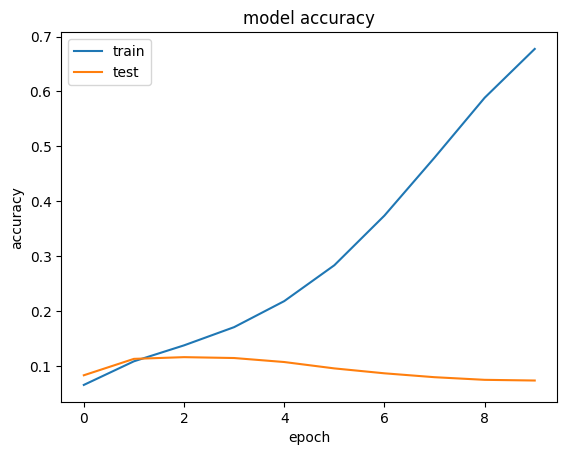

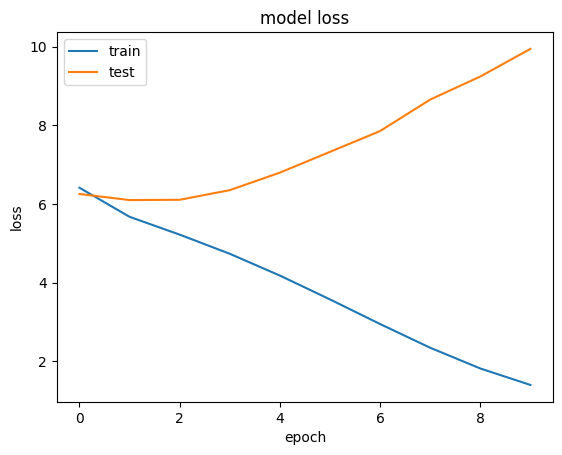

In [ ]:
plt.plot(history_LSTM['accuracy'])
plt.plot(history_LSTM['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_LSTM['loss'])
plt.plot(history_LSTM['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Fine-tuning BERT**

**Fine-tuning GPT-2**

In [ ]:
# Define a custom dataset for text generation
class TextGenerationDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return inputs


# Initialize the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Add a padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained('gpt2')

# Tokenize the full text data
text_tokens = tokenizer.tokenize(text)

# Split the tokens into training and test sets
split_ratio = 0.8  # Adjust this ratio as needed
random.shuffle(text_tokens)

split_index = int(len(text_tokens) * split_ratio)
training_tokens = text_tokens[:split_index]
test_tokens = text_tokens[split_index:]

# Convert tokens back to text for training and test
training_data = tokenizer.convert_tokens_to_string(training_tokens)
test_data = tokenizer.convert_tokens_to_string(test_tokens)

# Create datasets and dataloaders for training and test data
train_dataset = TextGenerationDataset([training_data], tokenizer)
test_dataset = TextGenerationDataset([test_data], tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=len(train_dataloader) * 10)

# Training loop
model.train()
epochs = 10
for epoch in range(epochs):
    total_loss = 0.0
    for batch in train_dataloader:
        inputs = batch['input_ids']
        optimizer.zero_grad()
        outputs = model(inputs, labels=inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {average_loss}")

# Evaluation on the test data and calculation of perplexity
model.eval()
total_test_loss = 0.0
with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch['input_ids']
        outputs = model(inputs, labels=inputs)
        loss = outputs.loss
        total_test_loss += loss.item()

average_test_loss = total_test_loss / len(test_dataloader)
test_perplexity = math.exp(average_test_loss)
print(f"Test Perplexity: {test_perplexity}")

# Now, you can generate text using the fine-tuned GPT-2 model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Average Loss: 7.931758880615234
Epoch 2/10, Average Loss: 7.913687229156494
Epoch 3/10, Average Loss: 7.707250118255615
Epoch 4/10, Average Loss: 7.7822771072387695
Epoch 5/10, Average Loss: 7.99185848236084
Epoch 6/10, Average Loss: 7.629101276397705
Epoch 7/10, Average Loss: 7.721099376678467
Epoch 8/10, Average Loss: 7.693967819213867
Epoch 9/10, Average Loss: 7.98684024810791
Epoch 10/10, Average Loss: 7.76936149597168
Test Perplexity: 1680.2217230879783


In [ ]:
import torch
from transformers import BertTokenizer, BertForMaskedLM, AdamW

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

tokens = tokenizer.tokenize(text)
num_words = 6  # Adjust this to your desired sequence length

# Ensure that the sequence length is at least 6
if len(tokens) < num_words:
    raise ValueError("Input text is too short for the specified sequence length.")

# Take the last 6 tokens for training
input_tokens = tokens[-num_words:]

# Mask the last token for prediction
masked_tokens = input_tokens.copy()
masked_tokens[-1] = "[MASK]"

# Convert tokens to input IDs
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
masked_input_ids = tokenizer.convert_tokens_to_ids(masked_tokens)

# Create attention masks
attention_mask = [1] * len(input_ids)

# Convert to PyTorch tensors
input_ids = torch.tensor([input_ids])
masked_input_ids = torch.tensor([masked_input_ids])
attention_mask = torch.tensor([attention_mask])

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Split data into train and test sets (assuming you have separate train and test data)
train_ratio = 0.8
split_index = int(input_ids.size(1) * train_ratio)

train_input_ids = input_ids[:, :split_index]
train_masked_input_ids = masked_input_ids[:, :split_index]
train_attention_mask = attention_mask[:, :split_index]

test_input_ids = input_ids[:, split_index:]
test_masked_input_ids = masked_input_ids[:, split_index:]
test_attention_mask = attention_mask[:, split_index:]

# Training loop
model.train()
epochs = 10
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(input_ids=train_masked_input_ids, attention_mask=train_attention_mask, labels=train_input_ids)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

    # Evaluation during training
    model.eval()
    with torch.no_grad():
        test_outputs = model(input_ids=test_masked_input_ids, attention_mask=test_attention_mask, labels=test_input_ids)
        test_loss = test_outputs.loss

        # Compute accuracy on the test set
        predicted_next_words = torch.argmax(test_outputs.logits, dim=-1)
        correct_predictions = (predicted_next_words == test_input_ids).sum().item()
        total_predictions = test_input_ids.numel()
        test_accuracy = correct_predictions / total_predictions

    print(f"Test Loss: {test_loss.item()}, Test Accuracy: {test_accuracy}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10, Loss: 7.6700215339660645
Test Loss: 4.861018180847168, Test Accuracy: 0.0
Epoch 2/10, Loss: 3.793754816055298
Test Loss: 4.884317398071289, Test Accuracy: 0.0
Epoch 3/10, Loss: 2.257817029953003
Test Loss: 4.869543552398682, Test Accuracy: 0.0
Epoch 4/10, Loss: 1.011042594909668
Test Loss: 4.8598175048828125, Test Accuracy: 0.0
Epoch 5/10, Loss: 0.2049376368522644
Test Loss: 4.851819038391113, Test Accuracy: 0.0
Epoch 6/10, Loss: 0.04772527143359184
Test Loss: 4.8455963134765625, Test Accuracy: 0.0
Epoch 7/10, Loss: 0.02266746386885643
Test Loss: 4.840639591217041, Test Accuracy: 0.0
Epoch 8/10, Loss: 0.012980755418539047
Test Loss: 4.836677074432373, Test Accuracy: 0.0
Epoch 9/10, Loss: 0.008243683725595474
Test Loss: 4.833521366119385, Test Accuracy: 0.0
Epoch 10/10, Loss: 0.005696252454072237
Test Loss: 4.83103084564209, Test Accuracy: 0.0
